In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

font = {'family': 'helvetica', 'size' :20}
plt.rc('font', **font)

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t, u, layers):
        
        # boundary conditions
        
        # data
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        #self.lambda_2 = torch.tensor([0.0], requires_grad=True).to(device)
        #self.lambda_3 = torch.tensor([10.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        #self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        #self.lambda_3 = torch.nn.Parameter(self.lambda_3)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        #self.dnn.register_parameter('lambda_2', self.lambda_2)
        #self.dnn.register_parameter('lambda_3', self.lambda_3)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-6, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1     
        #lambda_2 = self.lambda_2
        #lambda_3 = self.lambda_3
        
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * t* u ** 2 - 2*torch.pi*torch.cos(2*torch.pi*t) - t*torch.sin(2*torch.pi*t)**2
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.t)
        f_pred = self.net_f(self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        #self.optimizer.zero_grad()
        #loss.backward()
        
        # self.iter += 1
        # if self.iter % 100 == 0:
        #     print(
        #         'Loss: %e, l1: %.5f, l2: %.5f' % 
        #         (
        #             loss.item(), 
        #             self.lambda_1.item(),
        #             self.lambda_2.item()
        #             #self.lambda_3.item()
        #         )
        #     )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        It = []
        Loss = []
        lambda_1 = []
        #lambda_2 = []
        for epoch in range(nIter):
            u_pred = self.net_u(self.t)
            f_pred = self.net_f(self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item()
                        #self.lambda_2.item()
                        #self.lambda_3.item()
                    )
                )

                It.append(epoch)
                Loss.append(loss.item())
                lambda_1.append(self.lambda_1.item())
                #lambda_2.append(self.lambda_2.item())
            
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

        return(It, Loss, lambda_1)
        
    
    def predict(self, t):
        t = torch.tensor(t, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
t_b = np.array([0.0])
u_b = np.array([0.0])

t = np.linspace(0,1,100)

N_u = 50
exat_u = np.sin(2*np.pi*t)

idx = np.random.choice(t.shape[0], N_u, replace=False)
t_f = t[idx]
u_f = exat_u[idx]

t_data = np.concatenate([t_b,t_f]).reshape(51,1)
u_data = np.concatenate([u_b,u_f]).reshape(51,1)



It: 0, Loss: 2.068e+01, Lambda_1: 0.001
It: 100, Loss: 2.044e+01, Lambda_1: -0.011
It: 200, Loss: 1.995e+01, Lambda_1: -0.013
It: 300, Loss: 1.883e+01, Lambda_1: 0.125
It: 400, Loss: 1.676e+01, Lambda_1: 0.350
It: 500, Loss: 1.340e+01, Lambda_1: 0.658
It: 600, Loss: 6.674e+00, Lambda_1: 1.031
It: 700, Loss: 3.758e+00, Lambda_1: 1.214
It: 800, Loss: 2.540e+00, Lambda_1: 1.322
It: 900, Loss: 1.881e+00, Lambda_1: 1.405
It: 1000, Loss: 1.472e+00, Lambda_1: 1.476
It: 1100, Loss: 1.184e+00, Lambda_1: 1.538
It: 1200, Loss: 9.565e-01, Lambda_1: 1.593
It: 1300, Loss: 7.649e-01, Lambda_1: 1.642
It: 1400, Loss: 5.995e-01, Lambda_1: 1.685
It: 1500, Loss: 4.551e-01, Lambda_1: 1.722
It: 1600, Loss: 3.281e-01, Lambda_1: 1.752
It: 1700, Loss: 2.165e-01, Lambda_1: 1.775
It: 1800, Loss: 1.264e-01, Lambda_1: 1.790
It: 1900, Loss: 7.307e-02, Lambda_1: 1.799
It: 2000, Loss: 4.980e-02, Lambda_1: 1.803
It: 2100, Loss: 3.918e-02, Lambda_1: 1.806
It: 2200, Loss: 3.325e-02, Lambda_1: 1.808
It: 2300, Loss: 2.944

KeyboardInterrupt: 

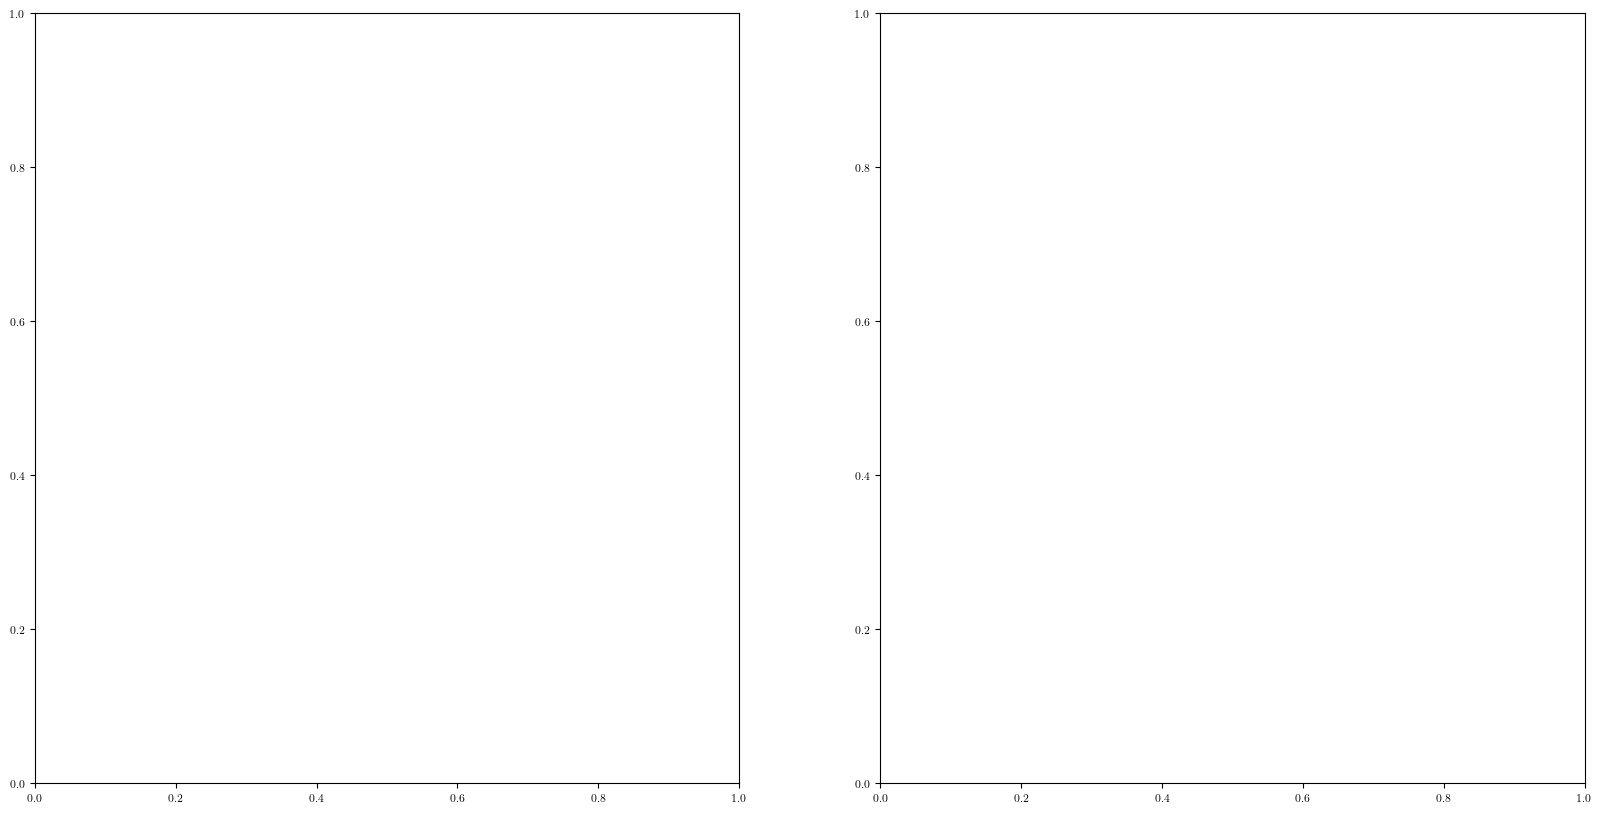

In [6]:
a = [1,2,4,7,10]
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1,2)

plot1 = plt.subplot(gs[0,0])
plot2 = plt.subplot(gs[0,1])

for i in range(len(a)):
    V1 = np.array([1])
    V2 = np.array([20]*a[i])
    V3 = np.array([1])
    layers = np.hstack([V1, V2, V3])
    model = PhysicsInformedNN(t_data, u_data, layers)
    It, Loss, Lambda_1 = model.train(20000)
    plot1.plot(It,np.abs(np.array(Lambda_1)-1),label = 'layers=%d'%a[i])  
    plot2.semilogy(It, Loss,label = 'layers=%d'%a[i]) 

plot1.set_xlabel('$iter$',fontsize=25)
plot1.set_ylabel('$|\lambda - \hat{\lambda}|$',fontsize=25)
plot1.set_title('Error of the $\lambda=1$ as a function of iteration')
plot1.legend(loc='upper right', fontsize=20)
plot1.tick_params(labelsize=25)

plot2.set_xlabel('$iter$',fontsize=25)
plot2.set_ylabel('Loss function',fontsize=25)
plot2.set_title('The loss function of iteration')
plot2.legend(loc='upper right', fontsize=20)
plot2.tick_params(labelsize=25)

plt.savefig("1st_nonlinear_lambda.pdf", format="pdf")

plt.show()


In [7]:
layers = [1, 20, 20, 1]


model = PhysicsInformedNN(t_data, u_data, layers)
model.train(5000)

t = t.reshape(100,1)
u_pred, f_pred = model.predict(t) 

It: 0, Loss: 2.062e+01, Lambda_1: -0.001
It: 100, Loss: 1.866e+01, Lambda_1: -0.008
It: 200, Loss: 3.455e+00, Lambda_1: 0.215
It: 300, Loss: 2.842e-02, Lambda_1: 0.266
It: 400, Loss: 1.515e-02, Lambda_1: 0.261
It: 500, Loss: 1.125e-02, Lambda_1: 0.268
It: 600, Loss: 9.009e-03, Lambda_1: 0.279
It: 700, Loss: 7.305e-03, Lambda_1: 0.292
It: 800, Loss: 5.849e-03, Lambda_1: 0.307
It: 900, Loss: 4.514e-03, Lambda_1: 0.323
It: 1000, Loss: 3.631e-03, Lambda_1: 0.339
It: 1100, Loss: 3.146e-03, Lambda_1: 0.356
It: 1200, Loss: 2.852e-03, Lambda_1: 0.374
It: 1300, Loss: 2.645e-03, Lambda_1: 0.394
It: 1400, Loss: 2.471e-03, Lambda_1: 0.415
It: 1500, Loss: 2.308e-03, Lambda_1: 0.437
It: 1600, Loss: 2.150e-03, Lambda_1: 0.459
It: 1700, Loss: 1.995e-03, Lambda_1: 0.483
It: 1800, Loss: 1.844e-03, Lambda_1: 0.506
It: 1900, Loss: 1.697e-03, Lambda_1: 0.530
It: 2000, Loss: 1.555e-03, Lambda_1: 0.554
It: 2100, Loss: 1.418e-03, Lambda_1: 0.578
It: 2200, Loss: 1.288e-03, Lambda_1: 0.603
It: 2300, Loss: 1.165

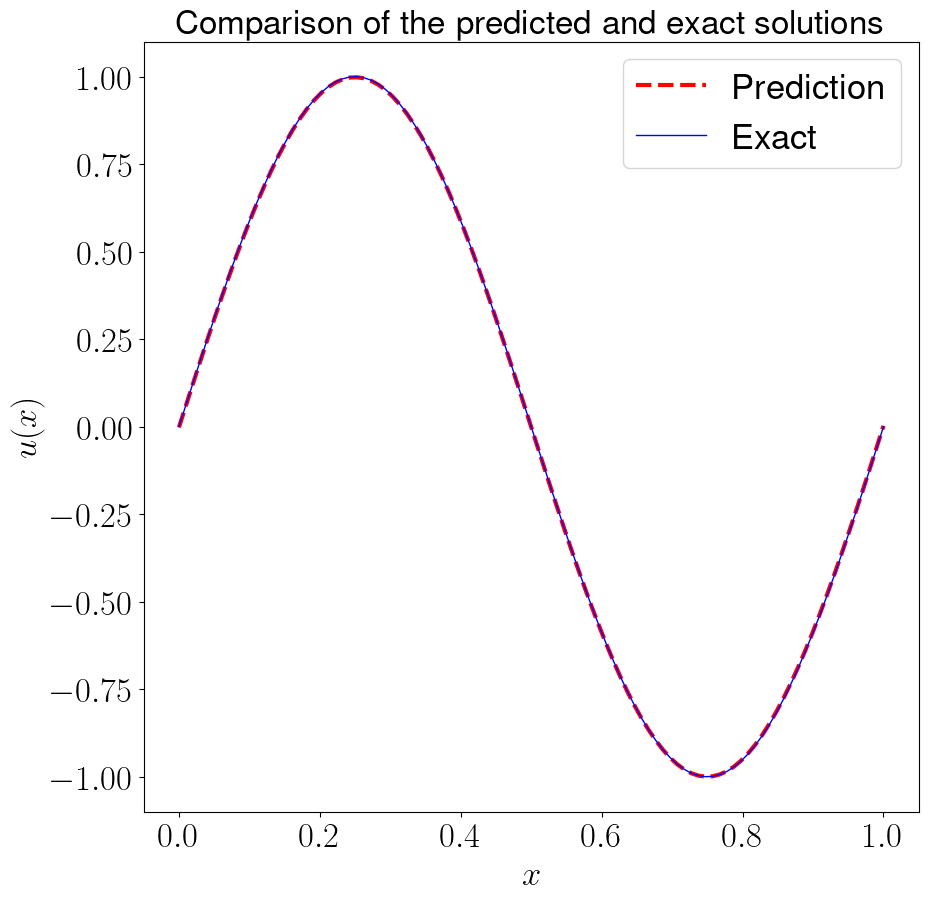

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(t,u_pred,'r--',linewidth = 3, label='Prediction')
ax.plot(t,exat_u,'b-', linewidth = 1, label = 'Exact')
ax.set_xlabel('$x$', fontsize=25)
ax.set_ylabel('$u(x)$', fontsize=25)
ax.set_title('Comparison of the predicted and exact solutions')
ax.legend(fontsize=25)
ax.tick_params(labelsize=25)

plt.savefig("1st_nonlinear_prediction.pdf", format="pdf")

plt.show()

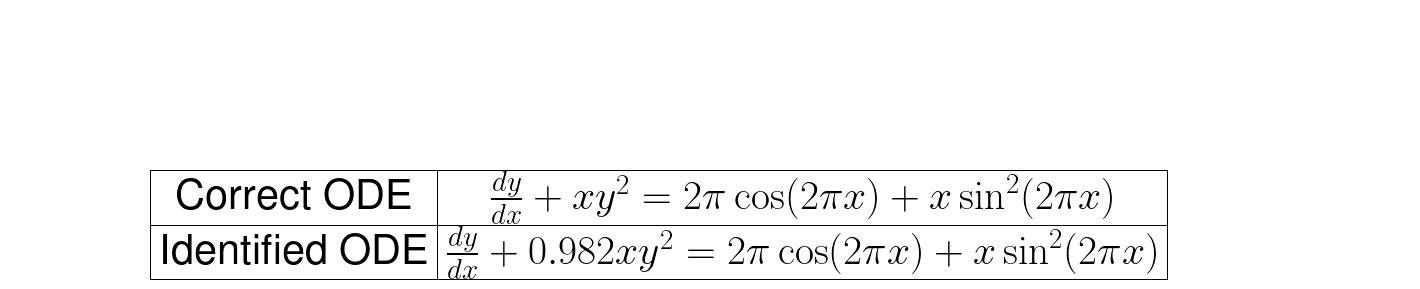

In [9]:
####### Row 3: Identified PDE ##################    
lambda_1_value = model.lambda_1[0]

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct ODE & $\frac{dy}{dx} + xy^2 = 2\pi\cos(2\pi x) + x \sin^2(2\pi x)$ \\  \hline Identified ODE & '
s2 = r'$\frac{dy}{dx} + %.3f xy^2 = 2\pi\cos(2\pi x) + x \sin^2(2\pi x)$ \\  \hline ' % (lambda_1_value)
s3 = r'\end{tabular}$'
s = s1+s2+s3
ax.text(0.1, 0.1, s, size=30)

plt.show()